# Flexible Single Body Models 

The goal of this project is to consider flexible single body models. We assume the door to be a flexible bar (or plate) attached to the bus. We wish to take the structural properties of the door (deformation, strain and stress) into account. We assume (for simplicity) that the door is a linear (small displacement around point of equilibrium in which the door is closed) and homogeneous (constant Lame parameters or Youngs' modulus) elastic medium. We wish to compare e.g. a rigid door and flexible suspension (expect large rigid displacement of the door, recover previous cases) with a flexible door and stiff suspension (expect large deformation of the door, recover case of flexible bar attached to reference). 

As before, we aim at 
1. a static analysis: one is typically interested in maximal displacements and stresses. For these quantities, analytical expressions do exist for the bar [using cantilever beam example for Euler–Bernoulli beam theory](https://en.wikipedia.org/wiki/Euler–Bernoulli_beam_theory) and for the plate using the [rectangular Kirchhoff-Love plate theory](https://en.wikipedia.org/wiki/Bending_of_plates). A comparison between analytical and numerical computations in made in [this example of the GXBEAM.jl package](https://flow.byu.edu/GXBeam.jl/dev/examples/tipforce/); 
2. a transient ansalysis: In a transient analysis, some form of the wave-equation needs to be solved (vibrasting plate theory). This can be handled by DifferentialEquations.jl. 
3. an eigenmode analysis; 
4. a vibration analysis; 

## Import Packages

In [12]:
using LinearAlgebra
using DifferentialEquations
using SparseArrays
using Plots
using LaTeXStrings
using BenchmarkTools 

## Flexible Bar Models

### Using Gridap 

### Alternative Tools to use 
1. [FinEtoolsFlexBeams](https://github.com/PetrKryslUCSD/FinEtoolsFlexBeamsTutorials.jl): includes vibrational analysis and assembly of beams;  
2. [GXBEAM](https://flow.byu.edu/GXBeam.jl/dev/): implementation of Geometrically Exact Beam Theory; includes vibrational analysis and assembly of beams; 
3. [the finite element package GridAp.jl](https://github.com/gridap/Gridap.jl) allows to describe the elastic deformation of flexible bodies. 

In [17]:
# this example was provided by Oriol Colomes on the #gridal Slack channel on July 31st 
#module EB_beam # Euler-Bernouilli 
using Gridap
# model = CartesianDiscreteModel((0,1),(10))  # Domain from 0 to 1, discretized with 10 elements
model = CartesianDiscreteModel((0,1),(100))  # Domain from 0 to 1, discretized with 10 elements
Ω = Interior(model) # Triangulation
Λ = Skeleton(Ω)     # Triangulation of the skeleton (interior nodes) -> used in the CG/DG approach to enforce continuity of rotations weakly
labels = get_face_labeling(model)
add_tag_from_tags!(labels,"left",[1,])  # Tag the left end node
add_tag_from_tags!(labels,"right",[2,]) # Tag the right end node (assume Free Neumann BC)
ΓD = Boundary(Ω,tags="left")
order = 1 # order = 2 # FE polynomial degree
refFE = ReferenceFE(lagrangian,Float64,order) # Lagrangian reference FE
V = TestFESpace(Ω,refFE,dirichlet_tags="left") # FE Space with Dirichlet BC at the left node
U = TrialFESpace(V,0.0) # Trial FE space with 0.0 deflection value at the Dirichlet BC
EI = 5.0e5 # Rigidity
h = 1/100   # Element size
γ = 1.0    # penalty constant
dΩ = Measure(Ω,2*order) # Integration measure for Ω
dΓ = Measure(ΓD,2*order) # Integration measure for ΓD
dΛ = Measure(Λ,2*order) # Integration measure for Λ
nΓ = get_normal_vector(ΓD) # normal vector at the boundary (this is a 1D vector in that case)
nΛ = get_normal_vector(Λ) # normal vector at the skeleton (this is a 1D vector in that case)
a(u,v) = ∫( EI*(Δ(u)*Δ(v)) )dΩ +
         ∫( EI * ( - Δ(u)*(∇(v)⋅nΓ) - (∇(u)⋅nΓ)*Δ(v) + γ/h*(∇(u)⋅nΓ)*(∇(v)⋅nΓ) ) )dΓ +
         ∫( EI * ( - mean(Δ(u))*jump(∇(v)⋅nΛ) - jump(∇(u)⋅nΛ)*mean(Δ(v)) + γ/h*jump(∇(u)⋅nΛ)*jump(∇(v)⋅nΛ) ) )dΛ
l(v) = ∫( -1.0*v )dΩ  # negative distributed force
op = AffineFEOperator(a,l,U,V)  # FE operator
uh = solve(op)
writevtk(Ω,"solution",cellfields=["u"=>uh])
#end

(["solution.vtu"],)

In [11]:
uhdof = get_free_dof_values(uh)

100-element Vector{Float64}:
 -9.999999995781384e-10
 -2.980099998738763e-9
 -5.92059999748622e-9
 -9.801999995824858e-9
 -1.4604999993759022e-8
 -2.0310499991293066e-8
 -2.6899599988431334e-8
 -3.435359998517818e-8
 -4.2653999981537943e-8
 -5.178249997751498e-8
 -6.172099997311364e-8
 -7.245159996833826e-8
 -8.395659996319321e-8
  ⋮
 -2.178185998821618e-6
 -2.211982498801079e-6
 -2.2457889987805094e-6
 -2.2796035987599142e-6
 -2.3134245987392982e-6
 -2.347250498718665e-6
 -2.3810799986980196e-6
 -2.414911998677366e-6
 -2.4487455986567084e-6
 -2.4825800986360504e-6
 -2.5164149986153925e-6
 -2.5502499985947345e-6

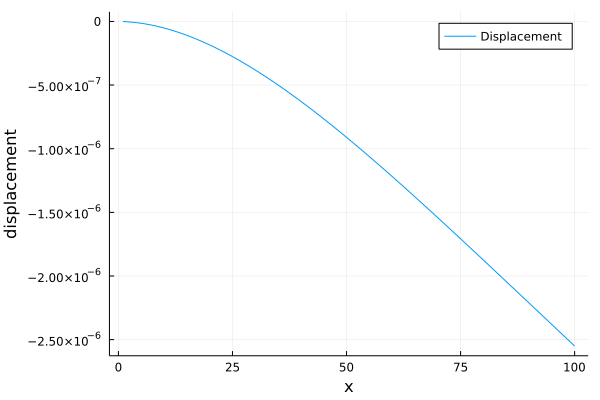

In [16]:
plot(uhdof,label="Displacement", fmt = :png)
xlabel!("x") 
ylabel!("displacement")

## Flexible Plate Models 
Using (non-)linear elasticity. 

In [2]:
using Gridap
model = DiscreteModelFromFile("../models/solid.json")

LoadError: SystemError: opening file "../models/solid.json": No such file or directory